In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)


In [3]:
ruta = r"C:\Users\beabr\Downloads\OneDrive\Formaciones\Data Analyst & AI\Proyectos\PROYECTO_FINAL\flights_final_atl.csv"

df_final = pd.read_csv(ruta)


C:\Users\beabr\AppData\Local\Temp\ipykernel_6496\3891101184.py:3: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_final = pd.read_csv(ruta)


In [4]:
# 1) Borrar columnas que no os aportan información relevante, o cuya información ya tenemos en otras columnas
cols_a_borrar = ["Unnamed: 0", "AIRLINE_DOT", "DOT_CODE", "ORIGIN_CITY"]
df_final = df_final.drop(columns=cols_a_borrar, errors="ignore")

# 2) Poner ORIGIN como primera columna, para ver claramente qué aeropuerto estamos analizando, ya que lo ideal, más adelante sería hacer el mismo ejercicio con otros aeropuertos
cols = df_final.columns.tolist()

if "ORIGIN" in cols:
    cols.remove("ORIGIN")
    df_final = df_final[["ORIGIN"] + cols]


In [5]:
import importlib
import src.limpieza_aeropuerto as la

importlib.reload(la)

df_final = la.clean_flights_df(df_final)
df_final.dtypes


ORIGIN                             object
FL_DATE                    datetime64[us]
AIRLINE_CODE                       object
FL_NUMBER                           int64
DEST                               object
CRS_DEP_TIME               string[python]
AIRLINE                            object
DEST_CITY                          object
DEP_TIME                   string[python]
TAXI_OUT                            Int64
WHEELS_OFF                 string[python]
WHEELS_ON                  string[python]
TAXI_IN                             Int64
CRS_ARR_TIME               string[python]
ARR_TIME                   string[python]
CRS_ELAPSED_TIME                    Int64
ELAPSED_TIME                        Int64
AIR_TIME                            Int64
DISTANCE                          float64
DEP_DELAY                         float64
ARR_DELAY                         float64
CANCELLED                           int64
CANCELLATION_CODE                  object
DIVERTED                          

In [6]:
import numpy as np
import pandas as pd

# 1) Tiempo: año / trimestre / mes / día semana
df_final["YEAR"] = df_final["FL_DATE"].dt.year
df_final["QUARTER"] = df_final["FL_DATE"].dt.quarter
df_final["MONTH"] = df_final["FL_DATE"].dt.month
df_final["WEEKDAY"] = df_final["FL_DATE"].dt.day_name()  # en inglés

# 2) Flags operativos (reglas)
df_final["IS_CANCELLED"] = df_final["CANCELLED"] == 1
df_final["IS_DIVERTED"] = df_final["DIVERTED"] == 1

# On-time arrival: ARR_DELAY <= 15 (solo si no está cancelado)
df_final["IS_ON_TIME_ARR"] = (df_final["ARR_DELAY"] <= 15) & (~df_final["IS_CANCELLED"])
df_final["IS_DELAYED_ARR"] = (df_final["ARR_DELAY"] > 15) & (~df_final["IS_CANCELLED"])

# 3) Buckets de retraso:
def delay_bucket(x):
    if pd.isna(x):
        return pd.NA
    if x < 0:
        return "Early (<0)"
    if x <= 15:
        return "0-15"
    if x <= 30:
        return "16-30"
    if x <= 60:
        return "31-60"
    return ">60"

df_final["DELAY_BUCKET"] = pd.NA
mask_not_cancelled = ~df_final["IS_CANCELLED"]
df_final.loc[mask_not_cancelled, "DELAY_BUCKET"] = df_final.loc[mask_not_cancelled, "ARR_DELAY"].apply(delay_bucket)

# 4) Schedule adherence: real - plan (min)
df_final["SCHED_DIFF_MIN"] = (df_final["ELAPSED_TIME"] - df_final["CRS_ELAPSED_TIME"]).astype("Int64")

# 5) Franja horaria (desde CRS_DEP_TIME "HH:MM")
df_final["CRS_DEP_HOUR"] = pd.to_numeric(df_final["CRS_DEP_TIME"].str[:2], errors="coerce")

def time_block(h):
    if pd.isna(h):
        return pd.NA
    h = int(h)
    if 6 <= h < 12:
        return "Mañana"
    if 12 <= h < 18:
        return "Mediodía"
    if 18 <= h < 24:
        return "Tarde"
    return "Noche"

df_final["TIME_BLOCK"] = df_final["CRS_DEP_HOUR"].apply(time_block).astype("string")


In [7]:
df_final.sample(7)

,ORIGIN,FL_DATE,AIRLINE_CODE,FL_NUMBER,DEST,CRS_DEP_TIME,AIRLINE,DEST_CITY,DEP_TIME,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DEP_DELAY,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,YEAR,QUARTER,MONTH,WEEKDAY,IS_CANCELLED,IS_DIVERTED,IS_ON_TIME_ARR,IS_DELAYED_ARR,DELAY_BUCKET,SCHED_DIFF_MIN,CRS_DEP_HOUR,TIME_BLOCK
124597,ATL,2023-03-01,DL,2050,BUF,15:30,Delta Air Lines Inc.,"Buffalo, NY",15:27,13,15:40,17:11,7,17:28,17:18,118,111,91,712.0,-3.0,-10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,2023,1,3,Wednesday,False,False,True,False,Early (<0),-7,15,Mediodía
57223,ATL,2022-01-23,DL,1171,LEX,14:53,Delta Air Lines Inc.,"Lexington, KY",14:48,10,14:58,15:51,5,16:04,15:56,71,68,53,304.0,-5.0,-8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,2022,1,1,Sunday,False,False,True,False,Early (<0),-3,14,Mediodía
124948,ATL,2019-03-27,YX,4439,LGA,21:17,Republic Airline,"New York, NY",21:13,15,21:28,23:21,5,23:41,23:26,144,133,113,762.0,-4.0,-15.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,2019,1,3,Wednesday,False,False,True,False,Early (<0),-11,21,Tarde
118452,ATL,2019-12-05,9E,5341,OAJ,15:26,Endeavor Air Inc.,"Jacksonville/Camp Lejeune, NC",15:21,27,15:48,16:50,4,16:52,16:54,86,93,62,399.0,-5.0,2.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,2019,4,12,Thursday,False,False,True,False,0-15,7,15,Mediodía
152341,ATL,2021-12-16,DL,383,LAX,21:20,Delta Air Lines Inc.,"Los Angeles, CA",21:23,20,21:43,23:13,15,23:16,23:28,296,305,270,1947.0,3.0,12.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,2021,4,12,Thursday,False,False,True,False,0-15,9,21,Tarde
50036,ATL,2021-06-22,WN,2012,JAN,19:00,Southwest Airlines Co.,"Jackson/Vicksburg, MS",19:16,12,19:28,19:19,3,19:25,19:22,85,66,51,341.0,16.0,-3.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,2021,2,6,Tuesday,False,False,True,False,Early (<0),-19,19,Tarde
796,ATL,2020-04-11,WN,5423,AUS,08:20,Southwest Airlines Co.,"Austin, TX",<NA>,<NA>,<NA>,<NA>,<NA>,09:55,<NA>,155,<NA>,<NA>,813.0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,2020,2,4,Saturday,False,False,False,False,<NA>,<NA>,8,Mañana


**__ANÁLISIS Y GRÁFICOS__**

YEAR,2019,2020,2021,2022,2023
AIRLINE,,,,,
Delta Air Lines Inc.,24978,15076,18768,21507,15163
Southwest Airlines Co.,4051,3031,3017,3283,2318
Endeavor Air Inc.,3901,4418,5810,2800,1336
Spirit Air Lines,918,646,869,1054,913
SkyWest Airlines Inc.,2860,732,83,659,670
Frontier Airlines Inc.,376,265,522,803,631
American Airlines Inc.,1300,636,741,682,612
United Air Lines Inc.,372,219,247,449,522
JetBlue Airways,338,169,259,221,242


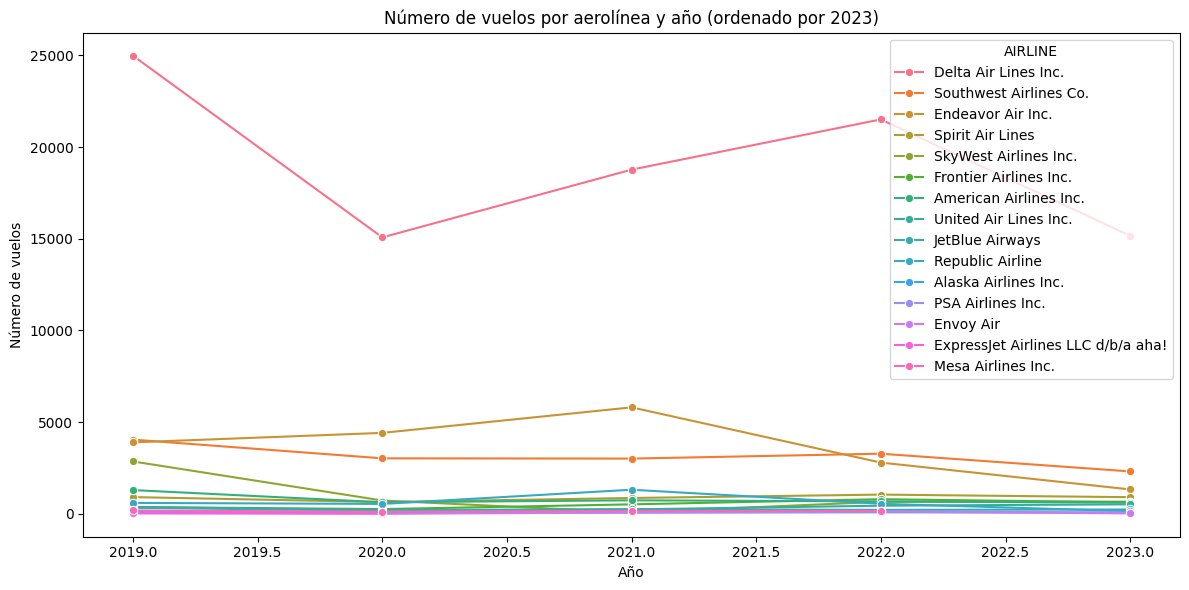

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tabla: nº de vuelos por aerolínea y año
vuelos_airline_year = (
    df_final
    .groupby(["AIRLINE", "YEAR"])
    .size()
    .reset_index(name="num_flights")
)

vuelos_pivot = (
    vuelos_airline_year
    .pivot(index="AIRLINE", columns="YEAR", values="num_flights")
    .fillna(0)
    .astype(int)
)

# Ordenar por el año 2023 (de mayor a menor)
if 2023 in vuelos_pivot.columns:
    vuelos_pivot = vuelos_pivot.sort_values(by=2023, ascending=False)

display(vuelos_pivot)

# Gráfica (ordenamos también para que el legend salga más coherente)
orden_airlines = vuelos_pivot.index.tolist()

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=vuelos_airline_year,
    x="YEAR",
    y="num_flights",
    hue="AIRLINE",
    hue_order=orden_airlines,
    marker="o"
)
plt.title("Número de vuelos por aerolínea y año (ordenado por 2023)")
plt.xlabel("Año")
plt.ylabel("Número de vuelos")
plt.tight_layout()
plt.show()




- Delta Air Lines concentra el mayor volumen de vuelos durante todo el periodo analizado, con una caída significativa en 2020 y una recuperación progresiva en los años posteriores. 
- El año 2020 muestra una reducción generalizada del número de vuelos en todas las aerolíneas, reflejando el impacto de la pandemia en la operativa aérea.
- A partir de 2021 se observa una recuperación gradual, aunque en 2023 varias aerolíneas aún no alcanzan los niveles previos a 2019.
- Aerolíneas como Southwest, Endeavor y Spirit mantienen volúmenes intermedios relativamente estables en comparación con el resto.
- El resto de aerolíneas presenta un volumen de vuelos significativamente menor, lo que justifica su menor peso en los análisis agregados posteriores.

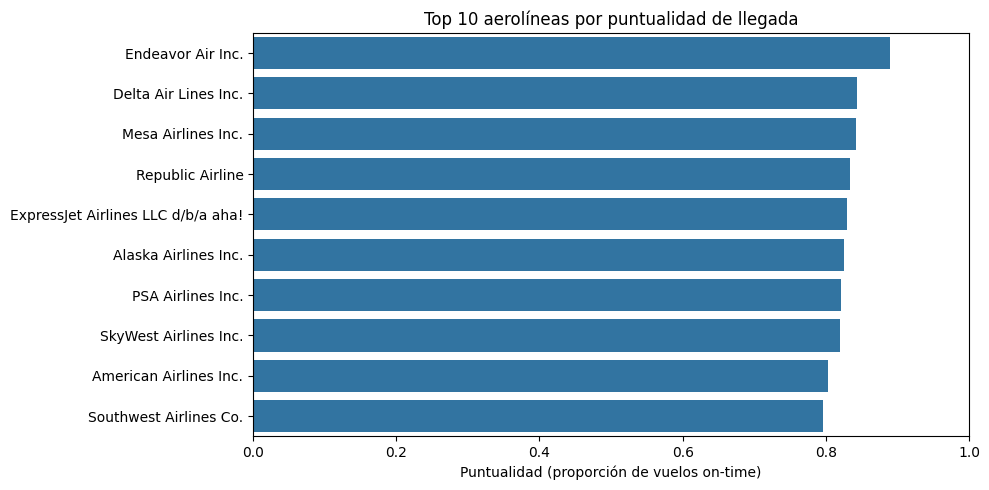

In [9]:
# 1) Filtrar vuelos válidos
df_ok = df_final[
    (df_final["IS_CANCELLED"] == False) &
    (df_final["IS_DIVERTED"] == False)
].copy()

# 2) Agrupar por aerolínea
puntualidad = (
    df_ok.groupby("AIRLINE")
    .agg(
        flights=("AIRLINE", "size"),
        on_time_rate=("IS_ON_TIME_ARR", "mean"),
        avg_arr_delay=("ARR_DELAY", "mean")
    )
    .reset_index()
)

# 3) (Opcional) Filtrar aerolíneas con pocos vuelos
puntualidad = puntualidad[puntualidad["flights"] >= 50]

# 4) Top 10 aerolíneas más puntuales
top10 = puntualidad.sort_values("on_time_rate", ascending=False).head(10)

# 5) Tabla resumen
top10[["AIRLINE", "flights", "on_time_rate", "avg_arr_delay"]]

# 6) Gráfico
plt.figure(figsize=(10, 5))
sns.barplot(data=top10, x="on_time_rate", y="AIRLINE")
plt.title("Top 10 aerolíneas por puntualidad de llegada")
plt.xlabel("Puntualidad (proporción de vuelos on-time)")
plt.ylabel("")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()



- El ranking muestra ciertas variaciones en los niveles de puntualidad de llegada entre aerolíneas, incluso dentro del top 10.
- Endeavor Air Inc. destaca como la aerolínea con mayor proporción de vuelos que llegan a tiempo, seguida de Delta Air Lines.
- Aerolíneas regionales como Republic, PSA, SkyWest y Mesa presentan niveles de puntualidad elevados y bastante homogéneos.
- American Airlines y Southwest Airlines se sitúan en la parte baja del ranking dentro del top 10, con una menor proporción de vuelos on-time.

YEAR,2019,2020,2021,2022,2023
AIRLINE_GROUP,,,,,
American Airlines Inc.,4.1,-1.1,1.8,9.2,17.9
Delta Air Lines Inc.,1.2,-2.4,0.6,2.8,8.3
Endeavor Air Inc.,0.6,-4.4,-4.2,3.3,2.9
Frontier Airlines Inc.,14.7,-6.2,5.4,25.3,35.8
JetBlue Airways,12.9,-1.9,14.3,29.7,34.4
Other,9.1,-7.1,-1.2,-1.6,8.3
Republic Airline,6.3,-4.9,1.7,3.7,0.7
SkyWest Airlines Inc.,4.6,2.5,-7.0,13.9,8.2
Southwest Airlines Co.,3.6,-7.6,3.5,5.3,9.4


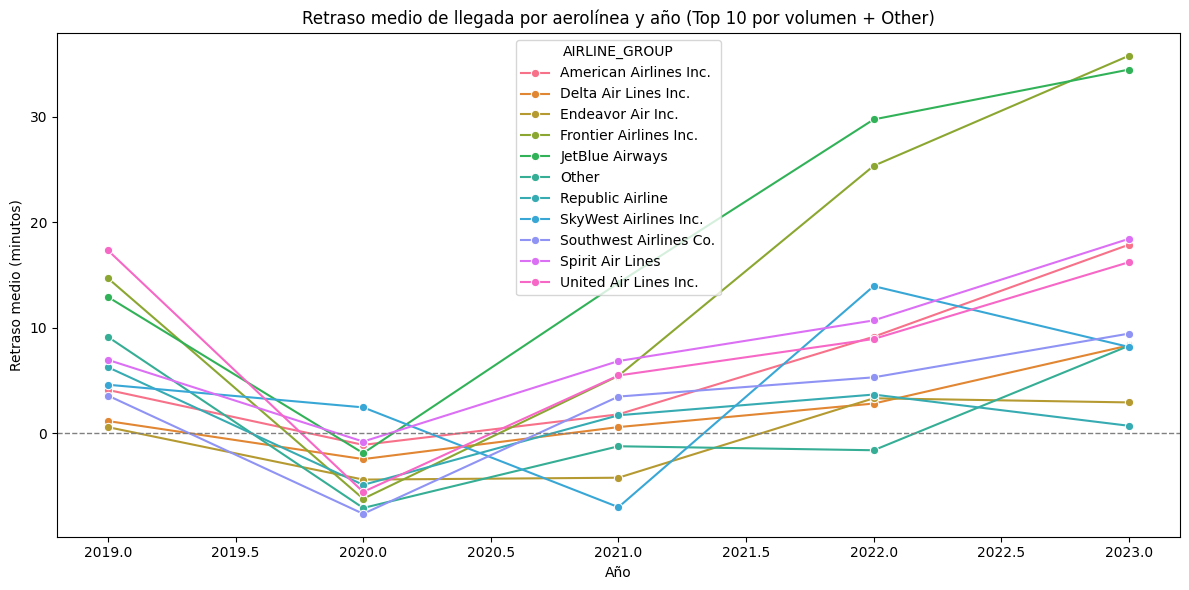

In [10]:
# 1) Filtrar vuelos válidos
df_ok = df_final[
    (df_final["IS_CANCELLED"] == False) &
    (df_final["IS_DIVERTED"] == False)
].copy()

# 2) Top 10 aerolíneas por volumen total
top10_airlines = (
    df_ok["AIRLINE"]
    .value_counts()
    .head(10)
    .index
)

# 3) Crear columna agrupada (Top 10 vs Other)
df_ok["AIRLINE_GROUP"] = df_ok["AIRLINE"].where(
    df_ok["AIRLINE"].isin(top10_airlines),
    "Other"
)

# 4) Retraso medio por aerolínea (agrupada) y año
delay_group_year = (
    df_ok
    .groupby(["AIRLINE_GROUP", "YEAR"])
    .agg(avg_arr_delay=("ARR_DELAY", "mean"))
    .reset_index()
)

# 5) Pivot (tabla)
delay_pivot = (
    delay_group_year
    .pivot(index="AIRLINE_GROUP", columns="YEAR", values="avg_arr_delay")
    .round(1)
)

display(delay_pivot)

# 6) Gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=delay_group_year,
    x="YEAR",
    y="avg_arr_delay",
    hue="AIRLINE_GROUP",
    marker="o"
)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Retraso medio de llegada por aerolínea y año (Top 10 por volumen + Other)")
plt.xlabel("Año")
plt.ylabel("Retraso medio (minutos)")
plt.tight_layout()
plt.show()


Para mejorar la legibilidad del análisis, se seleccionaron las 10 aerolíneas con mayor volumen total de vuelos. El resto de aerolíneas se agruparon bajo la categoría “Other”, calculando para ellas el retraso medio agregado por año. Esto permite identificar tendencias generales sin que el gráfico se vea distorsionado por aerolíneas con bajo volumen de operaciones.

- El año 2020 presenta un comportamiento atípico, con retrasos medios negativos en la mayoría de aerolíneas, lo que sugiere una menor congestión operativa y mayor capacidad de recuperación de tiempos de vuelo.
- A partir de 2021 se observa un deterioro progresivo de la puntualidad, que se acentúa claramente en 2022 y 2023.
- Frontier Airlines y JetBlue Airways destacan como las aerolíneas con mayor incremento del retraso medio, alcanzando en 2023 valores muy superiores al resto.
- Aerolíneas como Delta, Southwest y Republic muestran un comportamiento más estable, con aumentos de retraso más moderados a lo largo del periodo.
- El grupo “Other” sigue una evolución similar a la del conjunto de aerolíneas principales, lo que indica que el empeoramiento de la puntualidad es una tendencia general del sistema y no un fenómeno aislado.

En conjunto, los resultados reflejan que la recuperación del volumen de vuelos tras 2020 ha ido acompañada de un incremento significativo de los retrasos medios, especialmente en los últimos años analizados.

TIME_BLOCK,Mañana,Mediodía,Noche,Tarde
AIRLINE_GROUP,,,,
American Airlines Inc.,0.8,9.9,-9.5,17.1
Delta Air Lines Inc.,-1.3,1.9,-1.2,5.4
Endeavor Air Inc.,-3.1,-2.0,NaN,1.0
Frontier Airlines Inc.,9.1,14.4,3.5,37.2
JetBlue Airways,5.8,20.4,-9.0,40.2
Other,-4.8,0.9,-1.0,10.4
Republic Airline,-2.1,3.2,6.0,5.2
SkyWest Airlines Inc.,3.6,5.5,-8.0,8.9
Southwest Airlines Co.,-4.0,2.1,-13.0,12.8


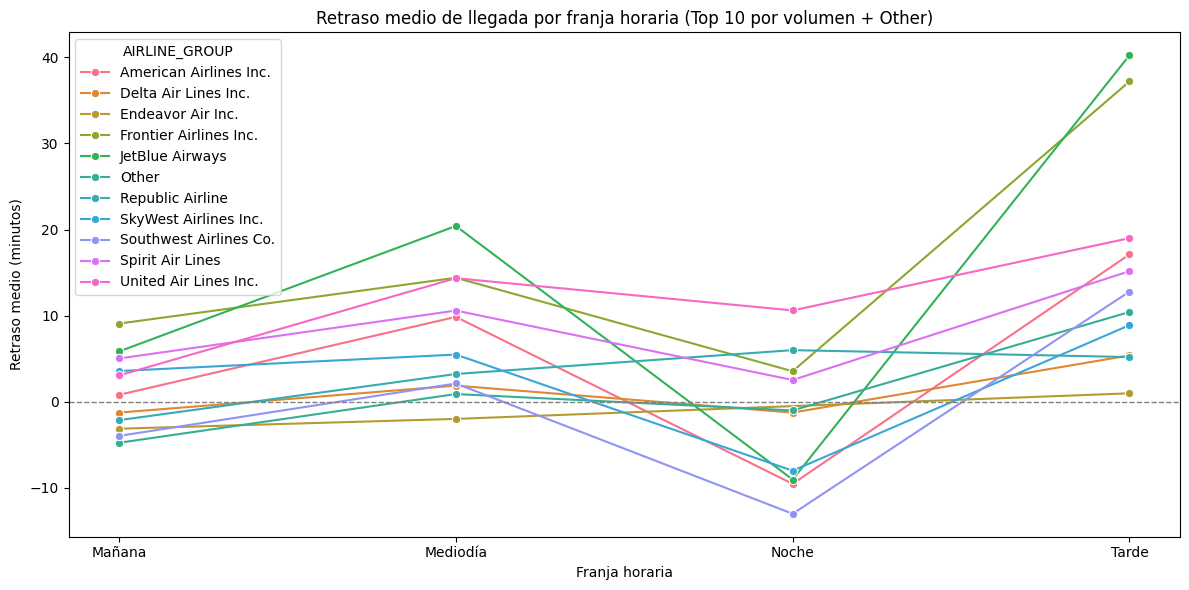

In [11]:

# 1) Filtrar vuelos válidos
df_ok = df_final[
    (df_final["IS_CANCELLED"] == False) &
    (df_final["IS_DIVERTED"] == False)
].copy()

# 2) Top 10 aerolíneas por volumen total
top10_airlines = df_ok["AIRLINE"].value_counts().head(10).index

# 3) Agrupar el resto como "Other"
df_ok["AIRLINE_GROUP"] = df_ok["AIRLINE"].where(df_ok["AIRLINE"].isin(top10_airlines), "Other")

# 4) Retraso medio por franja horaria y aerolínea (agrupada)
time_delay = (
    df_ok
    .groupby(["TIME_BLOCK", "AIRLINE_GROUP"])
    .agg(avg_arr_delay=("ARR_DELAY", "mean"))
    .reset_index()
)

# (Opcional) Ordenar TIME_BLOCK si no viene ordenado
order_time = ["Early Morning", "Morning", "Afternoon", "Evening", "Night"]
if set(order_time).issubset(set(time_delay["TIME_BLOCK"].unique())):
    time_delay["TIME_BLOCK"] = pd.Categorical(time_delay["TIME_BLOCK"], categories=order_time, ordered=True)
    time_delay = time_delay.sort_values("TIME_BLOCK")

# 5) Pivot (tabla)
time_pivot = (
    time_delay
    .pivot(index="AIRLINE_GROUP", columns="TIME_BLOCK", values="avg_arr_delay")
    .round(1)
)

display(time_pivot)

# 6) Gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=time_delay,
    x="TIME_BLOCK",
    y="avg_arr_delay",
    hue="AIRLINE_GROUP",
    marker="o"
)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Retraso medio de llegada por franja horaria (Top 10 por volumen + Other)")
plt.xlabel("Franja horaria")
plt.ylabel("Retraso medio (minutos)")
plt.tight_layout()
plt.show()


El análisis por franja horaria muestra un patrón consistente en todas las aerolíneas: los vuelos programados por la tarde presentan los mayores retrasos medios, mientras que los vuelos de primera hora de la mañana son los más puntuales. Este comportamiento sugiere un efecto acumulativo de retrasos a lo largo del día, independientemente de la aerolínea.

,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
AIRLINE_GROUP,,,,,
Delta Air Lines Inc.,423046.0,48477.0,168791.0,1735.0,146840.0
Southwest Airlines Co.,51802.0,3171.0,21658.0,450.0,70241.0
Endeavor Air Inc.,53454.0,20230.0,18951.0,89.0,30597.0
Frontier Airlines Inc.,24576.0,531.0,11924.0,0.0,27054.0
SkyWest Airlines Inc.,34861.0,9890.0,4438.0,93.0,14232.0
Spirit Air Lines,18712.0,1995.0,20353.0,259.0,21079.0
American Airlines Inc.,16810.0,1853.0,10847.0,188.0,28080.0
United Air Lines Inc.,6457.0,816.0,10710.0,0.0,12651.0
Republic Airline,11219.0,661.0,6679.0,16.0,11887.0


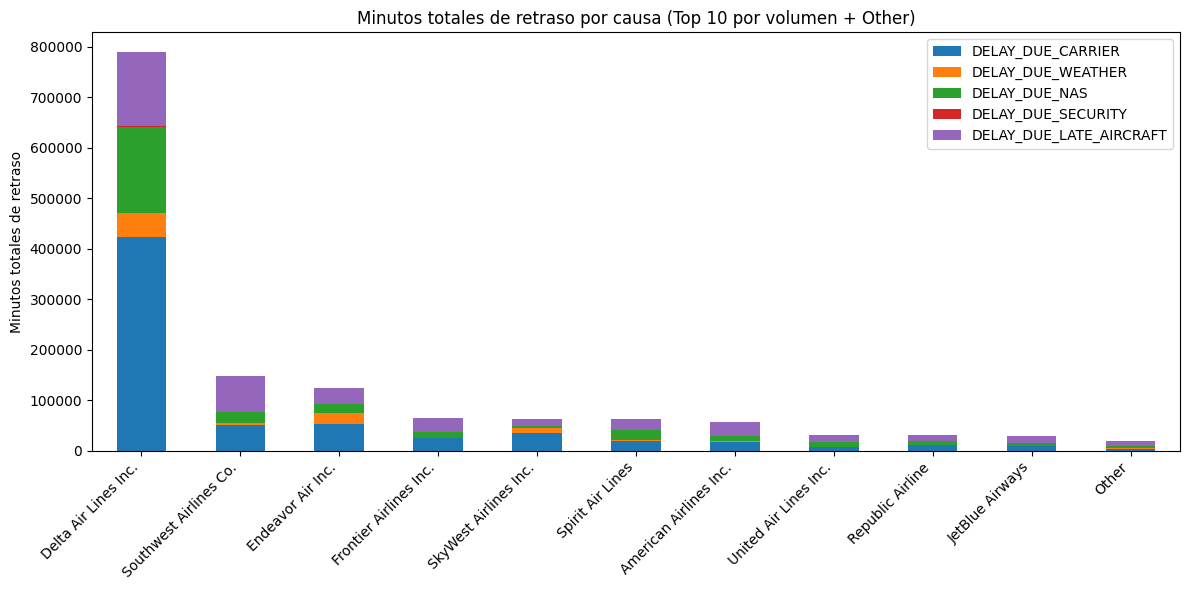

In [12]:
# 1) Filtrar vuelos válidos y con retraso real
df_ok = df_final[
    (df_final["IS_CANCELLED"] == False) &
    (df_final["IS_DIVERTED"] == False) &
    (df_final["ARR_DELAY"] > 0)
].copy()

# 2) Top 10 aerolíneas por volumen (en vuelos válidos)
top10_airlines = df_ok["AIRLINE"].value_counts().head(10).index
df_ok["AIRLINE_GROUP"] = df_ok["AIRLINE"].where(df_ok["AIRLINE"].isin(top10_airlines), "Other")

# 3) Columnas de causas (ajusta nombres si en tu df son distintos)
cause_cols = [
    "DELAY_DUE_CARRIER",
    "DELAY_DUE_WEATHER",
    "DELAY_DUE_NAS",
    "DELAY_DUE_SECURITY",
    "DELAY_DUE_LATE_AIRCRAFT"
]

# 4) Sumar minutos por causa y aerolínea (agrupada)
cause_sum = (
    df_ok
    .groupby("AIRLINE_GROUP")[cause_cols]
    .sum()
    .fillna(0)
)

# 5) Ordenar por total de minutos de retraso (para leerlo mejor)
cause_sum["TOTAL_DELAY_MIN"] = cause_sum.sum(axis=1)
cause_sum = cause_sum.sort_values("TOTAL_DELAY_MIN", ascending=False)
cause_sum = cause_sum.drop(columns="TOTAL_DELAY_MIN")

display(cause_sum)

# 6) Gráfico de barras apiladas
ax = cause_sum.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("Minutos totales de retraso por causa (Top 10 por volumen + Other)")
plt.xlabel("")
plt.ylabel("Minutos totales de retraso")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


- Los retrasos imputables a la aerolínea (Carrier Delay) representan la principal fuente de minutos de retraso en prácticamente todas las aerolíneas analizadas.
- La segunda causa más relevante es el retraso por llegada tardía de la aeronave (Late Aircraft), lo que refuerza la idea de un efecto arrastre en la operativa diaria.
- Los retrasos debidos a congestión del sistema aéreo (NAS) también tienen un peso significativo, especialmente en aerolíneas con mayor volumen de operaciones.
- Las causas meteorológicas (Weather) tienen un impacto menor en comparación con los factores operativos, y los retrasos por seguridad resultan residuales.
- Aerolíneas con mayor volumen de vuelos, como Delta y Southwest, concentran un mayor número total de minutos de retraso, lo que está directamente relacionado con su mayor actividad operativa.
- El grupo “Other” presenta un patrón similar al de las principales aerolíneas, indicando que la distribución de causas es consistente en todo el sistema.

,MONTH,num_cancelled,share_cancel
0,1,1,0.045455
1,2,1,0.045455
2,3,4,0.181818
3,4,2,0.090909
4,5,1,0.045455
5,6,5,0.227273
6,7,5,0.227273
7,8,2,0.090909
8,12,1,0.045455


CANCELLATION_CODE,A - Carrier (Aerolínea),B - Weather (Meteorología),C - NAS (Sistema aéreo),D - Security (Seguridad)
MONTH,,,,
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,1.0,2.0,0.0,1.0
4,0.0,2.0,0.0,0.0
5,0.0,1.0,0.0,0.0
6,4.0,0.0,1.0,0.0
7,2.0,2.0,1.0,0.0
8,2.0,0.0,0.0,0.0
12,0.0,1.0,0.0,0.0


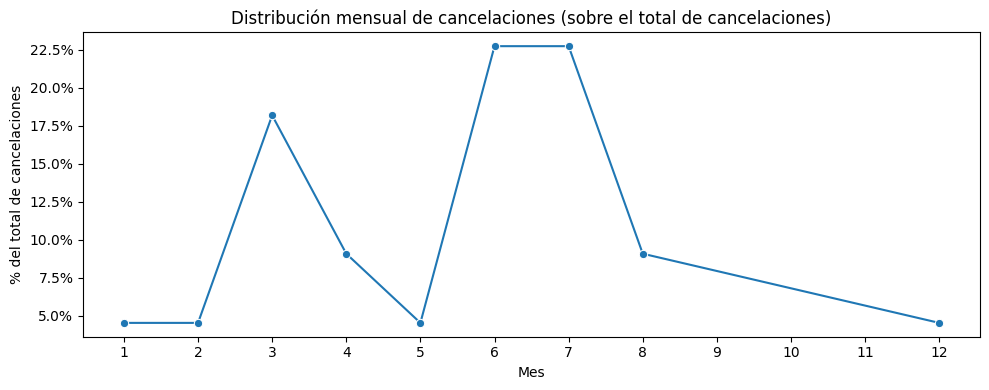

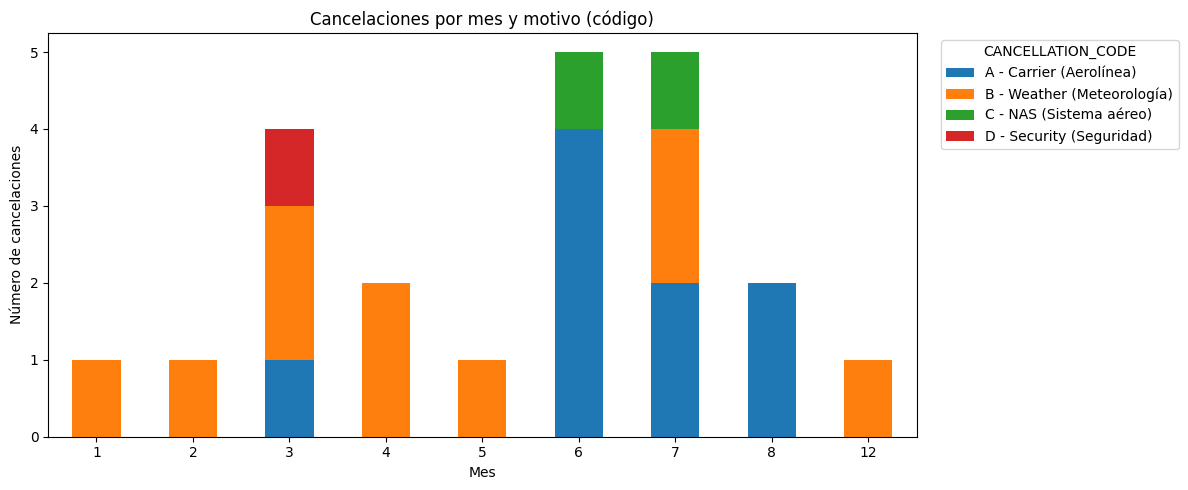

In [13]:
from matplotlib.ticker import PercentFormatter

df_c = df_final.copy()

# Si MONTH no existe, lo creamos desde FL_DATE
if "MONTH" not in df_c.columns and "FL_DATE" in df_c.columns:
    df_c["FL_DATE"] = pd.to_datetime(df_c["FL_DATE"], errors="coerce")
    df_c["MONTH"] = df_c["FL_DATE"].dt.month

# --- Mapeo de códigos de cancelación (estándar DOT) ---
code_map = {
    "A": "A - Carrier (Aerolínea)",
    "B": "B - Weather (Meteorología)",
    "C": "C - NAS (Sistema aéreo)",
    "D": "D - Security (Seguridad)"
}

# =========================
# GRÁFICO 1: % cancelaciones por mes (sobre el total de cancelaciones)
# =========================
cancel_only = df_c[df_c["IS_CANCELLED"] == True].copy()

cancel_month_counts = (
    cancel_only.groupby("MONTH")
    .size()
    .reset_index(name="num_cancelled")
    .sort_values("MONTH")
)

total_cancel = cancel_month_counts["num_cancelled"].sum()
cancel_month_counts["share_cancel"] = cancel_month_counts["num_cancelled"] / total_cancel

# =========================
# GRÁFICO 2: Cancelaciones por mes y código (barras apiladas)
# =========================
cancel_code_month = (
    cancel_only.groupby(["MONTH", "CANCELLATION_CODE"])
    .size()
    .reset_index(name="num_cancelled")
)

cancel_code_pivot = (
    cancel_code_month
    .pivot(index="MONTH", columns="CANCELLATION_CODE", values="num_cancelled")
    .fillna(0)
    .sort_index()
)

# Renombrar columnas para que la leyenda incluya el significado
cancel_code_pivot = cancel_code_pivot.rename(columns=lambda x: code_map.get(x, str(x)))

# ---- Mostrar tablas útiles ----
display(cancel_month_counts)
display(cancel_code_pivot)

# ---- Plot 1: % del total de cancelaciones por mes ----
plt.figure(figsize=(10, 4))
sns.lineplot(data=cancel_month_counts, x="MONTH", y="share_cancel", marker="o")
plt.title("Distribución mensual de cancelaciones (sobre el total de cancelaciones)")
plt.xlabel("Mes")
plt.ylabel("% del total de cancelaciones")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # 0-1 -> %
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

# ---- Plot 2: Barras apiladas por código ----
ax = cancel_code_pivot.plot(kind="bar", stacked=True, figsize=(12, 5))
plt.title("Cancelaciones por mes y motivo (código)")
plt.xlabel("Mes")
plt.ylabel("Número de cancelaciones")
plt.xticks(rotation=0)
plt.legend(title="CANCELLATION_CODE", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()



- Las cancelaciones se concentran principalmente en junio y julio, que representan la mayor parte del total anual de cancelaciones en la muestra.
- En términos de motivo, predominan los códigos A (Carrier / aerolínea) y B (Weather / meteorología), mientras que D (Security) aparece de forma residual.
- El número absoluto de cancelaciones es muy bajo (valores por mes pequeños), por lo que estas conclusiones deben interpretarse como tendencias indicativas dentro de la muestra, no como un patrón definitivo a nivel general.

In [14]:
# 1) Filtrar vuelos válidos
df_ok = df_final[
    (df_final["IS_CANCELLED"] == False) &
    (df_final["IS_DIVERTED"] == False)
].copy()

# 2) Top 10 aerolíneas por volumen
top10_airlines = df_ok["AIRLINE"].value_counts().head(10).index
df_ok = df_ok[df_ok["AIRLINE"].isin(top10_airlines)]

# 3) Medidas estadísticas del retraso de llegada
delay_stats = (
    df_ok
    .groupby("AIRLINE")["ARR_DELAY"]
    .agg(
        mean_delay="mean",
        std_delay="std",
        p25=lambda x: x.quantile(0.25),
        median=lambda x: x.quantile(0.50),
        p75=lambda x: x.quantile(0.75),
        p90=lambda x: x.quantile(0.90)
    )
    .round(1)
    .sort_values("mean_delay")
)

delay_stats


,mean_delay,std_delay,p25,median,p75,p90
AIRLINE,,,,,,
Endeavor Air Inc.,-1.5,39.4,-15.0,-9.0,-1.0,16.0
Republic Airline,1.8,42.8,-15.0,-8.0,2.0,29.8
Delta Air Lines Inc.,2.0,36.6,-13.0,-6.0,4.0,26.0
Southwest Airlines Co.,2.7,33.0,-14.0,-6.0,7.0,32.0
SkyWest Airlines Inc.,5.8,50.9,-14.0,-7.0,5.0,39.0
American Airlines Inc.,5.9,69.0,-18.0,-8.0,5.0,35.3
Spirit Air Lines,9.1,46.0,-12.0,-4.0,11.0,45.0
United Air Lines Inc.,10.6,58.3,-14.5,-4.0,11.5,54.0
JetBlue Airways,18.3,67.0,-13.0,-2.0,22.0,75.2


El análisis de dispersión revela que la calidad operativa no depende únicamente del retraso medio, sino también de la estabilidad del servicio. Aerolíneas con medias similares pueden ofrecer experiencias muy distintas en términos de fiabilidad, siendo la variabilidad y los retrasos extremos factores clave a considerar.
- La diferencia entre media y mediana en varias aerolíneas confirma la presencia de outliers, es decir, pocos vuelos con retrasos muy altos que influyen de forma significativa en la media.
- En particular, JetBlue y Frontier combinan retrasos medios elevados con alta dispersión, siendo las aerolíneas con mayor riesgo de retrasos extremos.

In [15]:
# Filtrar vuelos válidos
df_ok = df_final[
    (df_final["IS_CANCELLED"] == False) &
    (df_final["IS_DIVERTED"] == False)
][["DEP_DELAY", "ARR_DELAY", "TAXI_OUT", "TAXI_IN", "DISTANCE"]]

# Matriz de correlación
corr_matrix = df_ok.corr()

corr_matrix


,DEP_DELAY,ARR_DELAY,TAXI_OUT,TAXI_IN,DISTANCE
DEP_DELAY,1.000000,0.960187,0.051965,0.058056,0.028213
ARR_DELAY,0.960187,1.000000,0.214690,0.158975,0.009495
TAXI_OUT,0.051965,0.214690,1.000000,0.058432,0.034180
TAXI_IN,0.058056,0.158975,0.058432,1.000000,0.160531
DISTANCE,0.028213,0.009495,0.034180,0.160531,1.000000


- Existe una correlación muy fuerte entre el retraso de salida (DEP_DELAY) y el retraso de llegada (ARR_DELAY) (≈ 0.96), 
lo que indica que la mayor parte del retraso en la llegada se genera antes del despegue.

- El tiempo de rodaje previo al despegue (TAXI_OUT) muestra una correlación débil con el retraso de salida (≈ 0.05) 
y una correlación baja-moderada con el retraso de llegada (≈ 0.21), sugiriendo que la congestión en tierra contribuye al retraso, pero no es el factor principal.

- El tiempo de rodaje tras el aterrizaje (TAXI_IN) presenta una correlación baja con el retraso de llegada (≈ 0.16), 
indicando un impacto limitado en la puntualidad final.

- La distancia del vuelo (DISTANCE) muestra una correlación prácticamente nula con el retraso de llegada (≈ 0.01), 
lo que confirma que la duración del trayecto no explica los retrasos.

El análisis de correlaciones confirma que el retraso de llegada está fuertemente condicionado por el retraso en la salida, 
mientras que factores como la distancia del vuelo o el tiempo de rodaje tras el aterrizaje presentan una influencia limitada.

In [16]:
from scipy.stats import f_oneway

# 1) Filtrar vuelos válidos
df_ok = df_final[
    (df_final["IS_CANCELLED"] == False) &
    (df_final["IS_DIVERTED"] == False)
].copy()

# 2) Quedarnos solo con filas con TIME_BLOCK y ARR_DELAY válidos
df_ok = df_ok.dropna(subset=["TIME_BLOCK", "ARR_DELAY"])

# 3) Crear una lista de retrasos por franja horaria
groups = [
    group["ARR_DELAY"].values
    for _, group in df_ok.groupby("TIME_BLOCK")
]

# 4) Ejecutar ANOVA
f_stat, p_value = f_oneway(*groups)

f_stat, p_value


(np.float64(335.6230520837624), np.float64(3.093821720089596e-217))

Se realizó un contraste de hipótesis mediante un ANOVA de una vía para evaluar si el retraso medio de llegada difiere entre franjas horarias. El test muestra un resultado estadísticamente significativo (p < 0.05), por lo que se rechaza la hipótesis nula y se concluye que existen diferencias significativas en el retraso medio en función de la franja horaria.

In [18]:
df_final.sample(5)

,ORIGIN,FL_DATE,AIRLINE_CODE,FL_NUMBER,DEST,CRS_DEP_TIME,AIRLINE,DEST_CITY,DEP_TIME,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DEP_DELAY,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,YEAR,QUARTER,MONTH,WEEKDAY,IS_CANCELLED,IS_DIVERTED,IS_ON_TIME_ARR,IS_DELAYED_ARR,DELAY_BUCKET,SCHED_DIFF_MIN,CRS_DEP_HOUR,TIME_BLOCK
33459,ATL,2022-12-22,DL,1727,HSV,18:59,Delta Air Lines Inc.,"Huntsville, AL",18:54,11,19:05,18:40,5,18:53,18:45,54,51,35,151.0,-5.0,-8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,2022,4,12,Thursday,False,False,True,False,Early (<0),-3,18,Tarde
144390,ATL,2021-10-21,UA,248,IAD,10:00,United Air Lines Inc.,"Washington, DC",09:55,29,10:24,11:40,4,11:49,11:44,109,109,76,534.0,-5.0,-5.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,2021,4,10,Thursday,False,False,True,False,Early (<0),0,10,Mañana
104280,ATL,2022-09-13,NK,3877,DTW,14:25,Spirit Air Lines,"Detroit, MI",14:25,13,14:38,16:00,11,16:19,16:11,114,106,82,594.0,0.0,-8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,2022,3,9,Tuesday,False,False,True,False,Early (<0),-8,14,Mediodía
151058,ATL,2020-03-07,B6,996,BOS,06:00,JetBlue Airways,"Boston, MA",06:26,9,06:35,08:39,4,08:28,08:43,148,137,124,946.0,26.0,15.0,0,NaN,0,15.0,0.0,0.0,0.0,0.0,2020,1,3,Saturday,False,False,True,False,0-15,-11,6,Mañana
106876,ATL,2021-07-17,DL,2441,EWR,08:24,Delta Air Lines Inc.,"Newark, NJ",08:31,18,08:49,10:31,4,10:30,10:35,126,124,102,746.0,7.0,5.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,2021,3,7,Saturday,False,False,True,False,0-15,-2,8,Mañana


Al empezar a trabajar con el Dasboards de EXCEL,vemos que nos vendrían bien alfunas columnas que no habíamos añadido, por lo que volvemos aquí a añadir dichas columnas a nuestra base de datos:

In [20]:
# 1) Pasar True/False a 1/0
df_final["IS_ON_TIME_ARR_0/1"] = df_final["IS_ON_TIME_ARR"].map({True: 1, False: 0})
df_final["IS_DELAYED_ARR_0/1"] = df_final["IS_DELAYED_ARR"].map({True: 1, False: 0})

# Guardar cambios
df_final.to_csv(ruta, index=False)

df_final[[
    "IS_ON_TIME_ARR",
    "IS_ON_TIME_ARR_01",
    "IS_DELAYED_ARR",
    "IS_DELAYED_ARR_01"
]].head()



,IS_ON_TIME_ARR,IS_ON_TIME_ARR_01,IS_DELAYED_ARR,IS_DELAYED_ARR_01
0,False,0,True,1
1,True,1,False,0
2,True,1,False,0
3,True,1,False,0
4,True,1,False,0


In [24]:
# 2) Descripción del motivo de cancelación
cancel_map = {
    "A": "Carrier",
    "B": "Weather",
    "C": "NAS",
    "D": "Security"
}

df_final["CANCELLATION_REASON_DESC"] = df_final["CANCELLATION_CODE"].map(cancel_map)

df_final[["CANCELLATION_CODE", "CANCELLATION_REASON_DESC"]].head()


,CANCELLATION_CODE,CANCELLATION_REASON_DESC
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [25]:
# 3) Texto con el/los motivos del retraso según qué columnas tengan minutos > 0
delay_cols = {
    "DELAY_DUE_CARRIER": "Carrier",
    "DELAY_DUE_WEATHER": "Weather",
    "DELAY_DUE_NAS": "NAS",
    "DELAY_DUE_SECURITY": "Security",
    "DELAY_DUE_LATE_AIRCRAFT": "Late Aircraft"
}

# Asegura que son numéricas (por si vienen como texto)
for c in delay_cols:
    df_final[c] = pd.to_numeric(df_final[c], errors="coerce").fillna(0)

def delay_reason_text(row):
    reasons = [desc for col, desc in delay_cols.items() if row[col] > 0]
    return " + ".join(reasons) if reasons else np.nan

df_final["DELAY_REASON_DESC"] = df_final.apply(delay_reason_text, axis=1)

df_final[["DELAY_REASON_DESC"] + list(delay_cols.keys())].head()


,DELAY_REASON_DESC,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,Carrier,60.0,0.0,0.0,0.0,0.0
1,NaN,0.0,0.0,0.0,0.0,0.0
2,NaN,0.0,0.0,0.0,0.0,0.0
3,NaN,0.0,0.0,0.0,0.0,0.0
4,NaN,0.0,0.0,0.0,0.0,0.0


In [27]:
# Guardar CSV actualizado
csv_path = r"C:\Users\beabr\Downloads\OneDrive\Formaciones\Data Analyst & AI\Proyectos\PROYECTO_FINAL\flights_final_atl.csv"
df_final.to_csv(csv_path, index=False)

# Crear archivo Excel
excel_path = r"C:\Users\beabr\Downloads\OneDrive\Formaciones\Data Analyst & AI\Proyectos\PROYECTO_FINAL\flights_final_atl_clean_V2.xlsx"
df_final.to_excel(excel_path, index=False)
